# Procesamiento de datos del dataset

In [1]:
!git config --global user.email "Matias.telo000@gmail.com"
!git config --global user.name "MatiasTelo"

!git clone https://github.com/MatiasTelo/Global-Redes-Neuronales-Telo-Blangetti
# Crear carpetas de destino

print("Archivos copiados con éxito.")

Cloning into 'Global-Redes-Neuronales-Telo-Blangetti'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 82 (delta 33), reused 69 (delta 30), pack-reused 0 (from 0)
Receiving objects: 100% (82/82), 39.43 MiB | 16.02 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Archivos copiados con éxito.


El procesamiento del dataset se realizo de la siguiente manera:



*   Primero definimos el vocabulario y creamos un diccionario para pasar de caracter a numero y viceversa
*   Luego obtenemos los txt descargados del dataset y los guardamos en una variable
*   Guardamos el diccionario de char to index
*   En prepare_segments lo que hacemos es dividir los txt primero en 14 filas para definir el alto del segmento y luego lo dividimos en 32 columnas para el ancho, nos aseguramos de llenar espacios si faltan y cada segmento se agrega al array de segments
*   En get item lo que hacemos es a cada segmento agregarle una dimension adicional del tamaño del vocabulario para hacer un one-hot de cada caracter


Adicionalmente agregamos una funcion para visualizar los segmentos que nos devuelve el dataset que nos sirve de utilidad para ver que todo se haya procesado bien y ademas para cuando generemos segmentos con la gan tambien podamos usar esta funcion para verlos



In [2]:

import glob
import torch.nn.functional as F
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

# Definir el vocabulario
CHARACTER_SET = ['X', 'S', '-', '?', 'Q', 'E', '<', '>', '[', ']', 'o', 'B', 'b']
char2idx = {char: idx for idx, char in enumerate(CHARACTER_SET)}
idx2char = {idx: char for char, idx in char2idx.items()}
VOCAB_SIZE = len(CHARACTER_SET)

class MarioLevelDataset(Dataset):
    def __init__(self, folder_path, level_height=14, segment_width=32, step=16, char2idx=None):
        super().__init__()
        self.level_files = glob.glob(os.path.join(folder_path, '*.txt'))
        self.level_height = level_height
        self.segment_width = segment_width
        self.step = step

        # Mapa char->idx obligatorio
        if char2idx is None:
            raise ValueError("Debes pasar un diccionario char2idx")
        self.char2idx = char2idx

        # Aquí guardamos todos los segmentos de todos los niveles
        self.segments = []
        self._prepare_segments()

    def _prepare_segments(self):
        for file_path in self.level_files:
            with open(file_path, 'r') as f:
                lines = f.readlines()
            # Limpio líneas y fijo altura
            lines = [line.rstrip('\n')[:] for line in lines[:self.level_height]]
            # Completo si faltan filas
            while len(lines) < self.level_height:
                lines.append('-' * len(lines[0]))

            level_width = max(len(line) for line in lines)
            # Completo cada línea a nivel_width (con '-')
            lines = [line.ljust(level_width, '-') for line in lines]

            # Segmentar horizontalmente con step
            for start_col in range(0, level_width - self.segment_width + 1, self.step):
                segment = [line[start_col:start_col+self.segment_width] for line in lines]
                self.segments.append(segment)

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
      segment = self.segments[idx]
      arr = [[self.char2idx.get(ch, 0) for ch in row] for row in segment]
      tensor = torch.tensor(arr, dtype=torch.long)
      one_hot = F.one_hot(tensor, num_classes=len(self.char2idx))  # (14, 32, vocab)
      one_hot = one_hot.permute(2, 0, 1)  # -> (vocab, 14, 32)
      return one_hot.float()


In [3]:
# Rutas y parámetros
data_path = 'Global-Redes-Neuronales-Telo-Blangetti/data/Processed'
batch_size = 32
train_ratio = 0.8

# Cargar dataset
dataset = MarioLevelDataset(folder_path=data_path, char2idx=char2idx)
# DataLoaders
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


# Utilidad para visualizacion

In [4]:
from PIL import Image
import os

def cargar_sprites(path="Global-Redes-Neuronales-Telo-Blangetti/data/Sprites"):
    """
    Carga las imágenes PNG de tiles en un diccionario: {char: PIL.Image}
    """
    sprites = {}
    for filename in os.listdir(path):
        if filename.endswith(".png"):
            key = os.path.splitext(filename)[0]  # nombre sin extensión
            if key == "D":
                key = "<"
            elif key == "I":
                key = ">"
            elif key == "P":
                key = "B"
            elif key == "A":
                key = "?"
            sprites[key] = Image.open(os.path.join(path, filename)).convert("RGBA")
    return sprites


In [5]:
import numpy as np
from PIL import Image

def tensor_a_imagen(one_hot_tensor, idx2char, sprites, tile_size=(16, 16)):
    """
    Convierte un tensor one-hot (VOCAB_SIZE, 14, 32) en una imagen compuesta de sprites.
    """
    idx_tensor = one_hot_tensor.argmax(dim=0).cpu().numpy()  # (14, 32)

    rows, cols = idx_tensor.shape
    tile_width, tile_height = tile_size

    # Crear imagen en blanco del tamaño total
    output = Image.new('RGBA', (cols * tile_width, rows * tile_height))

    for y in range(rows):
        for x in range(cols):
            char = idx2char[idx_tensor[y][x]]
            sprite = sprites.get(char, None)
            if sprite:
                output.paste(sprite, (x * tile_width, y * tile_height), mask=sprite)
    return output
sprites = cargar_sprites()

# Visualizacion de segmentos

In [6]:
def visualizar_segmento(one_hot_tensor, idx2char):
    """
    Convierte un tensor one-hot (VOCAB_SIZE, 14, 32) a texto y lo imprime.
    """
    # (VOCAB_SIZE, 14, 32) → (14, 32) con los índices de mayor probabilidad
    idx_tensor = one_hot_tensor.argmax(dim=0).cpu().numpy()

    # Convertir cada índice a su carácter correspondiente
    for row in idx_tensor:
        line = ''.join(idx2char[i] for i in row)
        print(line)



In [7]:

# Elegí un índice de segmento, por ejemplo el primero
segmento = dataset[347]  # (VOCAB_SIZE, 14, 32)

# Visualizarlo
visualizar_segmento(segmento, idx2char)


--------------------------------
--------------------------------
--------------------------------
--------------------------------
--ooo---------------------------
-------------E---E---------X----
--------------------------------
--------------------------------
--------------------------------
----------------------X---------
--------------------------------
--------------------------------
--------------------------------
----XXXXXXXXXXXXXX--------------


# Definicion de modelos

In [8]:
import torch
from torch import nn
from torch.nn.utils import spectral_norm

VOCAB_SIZE = 13
z = torch.randn(32, 100, 1, 4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Modelo 1: Bloques densos

Este modelo GAN está compuesto por un generador y un discriminador que utilizan bloques densos inspirados en DenseNet, adaptados al contexto de generación de niveles 2D.

**Generador**
*   Utiliza DenseGBlock, una combinación de ConvTranspose2d para upsampling seguida de un DenseBlock para ampliar la capacidad de aprendizaje.
*   Empieza con una proyección desde el vector latente y luego realiza upsampling progresivo
*   Al final, usa una convolución transpuesta para producir una imagen con 13 canales (formato one-hot).
* La activación final Tanh() normaliza los valores de salida entre -1 y 1.

🔧 Bloques principales:

3 DenseGBlock para escalado progresivo.

2 DenseBlock finales para refinar la imagen.

Salida final con forma ajustada para representar niveles.


**Discriminador**
* Emplea DenseDBlock, que combina downsampling (Conv2d) con DenseBlock.

* Integra spectral normalization opcional para estabilizar el entrenamiento.

* Finaliza con una convolución 1x4 para evaluar regiones completas del nivel, y un Flatten para producir el resultado final.

🔧 Bloques principales:

3 DenseDBlock con downsampling.

2 DenseBlock intermedios para refinamiento.

Capa final para clasificación real/falso.

In [9]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate=32, num_layers=4):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        self.growth_rate = growth_rate

        channels = in_channels
        for _ in range(num_layers):
            self.layers.append(nn.Sequential(
                nn.BatchNorm2d(channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(channels, growth_rate, kernel_size=3, padding=1, bias=False)
            ))
            channels += growth_rate

        self.transition = nn.Sequential(
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, in_channels, kernel_size=1, bias=False)
        )

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            out = layer(torch.cat(features, 1))
            features.append(out)
        return self.transition(torch.cat(features, 1))


### Generador

In [10]:
class DenseGBlock(nn.Module):
    """
    Dense block para el generador, con upsampling (ConvTranspose2d).
    """
    def __init__(self, in_channels, out_channels, growth_rate=32, num_layers=4,
                 kernel_size=4, stride=2, padding=1):
        super(DenseGBlock, self).__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels,
                                           kernel_size=kernel_size,
                                           stride=stride,
                                           padding=padding,
                                           bias=False)
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Dense layers después del upsampling
        self.dense_block = DenseBlock(out_channels, growth_rate=growth_rate, num_layers=num_layers)

    def forward(self, x):
        x = self.upsample(x)
        x = self.relu(self.norm(x))
        x = self.dense_block(x)
        return x

class Generator1(nn.Module):
    def __init__(self, vocab_size, latent_dim=100, n_G=64):
        super(Generator1, self).__init__()
        self.net = nn.Sequential(
            DenseGBlock(in_channels=latent_dim, out_channels=n_G * 8,
                        kernel_size=(3, 5), stride=(1, 2), padding=(0, 1)),  # (512, 3, 8)

            DenseGBlock(in_channels=n_G * 8, out_channels=n_G * 4),
            DenseGBlock(in_channels=n_G * 4, out_channels=n_G * 2),

            DenseBlock(in_channels=n_G * 2),
            DenseBlock(in_channels=n_G * 2),

            nn.ConvTranspose2d(n_G * 2, vocab_size,
                               kernel_size=(3, 1),
                               stride=(1, 1),
                               padding=(0, 2), bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)


### Discriminador

In [11]:

class DenseDBlock(nn.Module):
    """
    Dense block para el discriminador, con downsampling (Conv2d).
    """
    def __init__(self, in_channels, out_channels, growth_rate=32, num_layers=4,
                 kernel_size=4, stride=2, padding=1, alpha=0.2, use_spectralnorm=False, dropout=0.0):
        super(DenseDBlock, self).__init__()

        conv = nn.Conv2d(in_channels, out_channels,
                         kernel_size=kernel_size,
                         stride=stride,
                         padding=padding,
                         bias=False)
        if use_spectralnorm:
            conv = spectral_norm(conv)

        self.conv = conv
        self.act = nn.LeakyReLU(alpha, inplace=True)
        self.dropout = nn.Dropout2d(dropout) if dropout > 0.0 else nn.Identity()

        # Dense layers después del downsampling
        self.dense_block = DenseBlock(out_channels, growth_rate=growth_rate, num_layers=num_layers)

    def forward(self, x):
        x = self.conv(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.dense_block(x)
        return x




class Discriminator1(nn.Module):
    def __init__(self, vocab_size, n_D=64, use_spectralnorm=True):
        super(Discriminator1, self).__init__()
        self.net = nn.Sequential(
            DenseDBlock(in_channels=vocab_size, out_channels=n_D,
                        use_spectralnorm=use_spectralnorm),
            DenseDBlock(in_channels=n_D, out_channels=n_D * 2,
                        use_spectralnorm=use_spectralnorm),

            DenseBlock(in_channels=n_D * 2),
            DenseBlock(in_channels=n_D * 2),

            DenseDBlock(in_channels=n_D * 2, out_channels=n_D * 4,
                        use_spectralnorm=use_spectralnorm),

            nn.Conv2d(in_channels=n_D * 4, out_channels=1,
                      kernel_size=(1, 4), stride=1, padding=0),

            nn.Flatten()
        )

    def forward(self, x):
        return self.net(x)


In [12]:
VOCAB_SIZE = 13
z = torch.randn(32, 100, 1, 4)

G1 = Generator1(vocab_size=VOCAB_SIZE)
D1 = Discriminator1(vocab_size=VOCAB_SIZE)

fake1 = G1(z)
logits1 = D1(fake1)

print(fake1.shape)   # torch.Size([32, 13, 14, 32])
print(logits1.shape) # torch.Size([32, 1])


torch.Size([32, 13, 14, 32])
torch.Size([32, 1])


## Modelo 2: Bloques residuales


Este segundo modelo GAN está construido a partir de bloques residuales, una arquitectura inspirada en ResNet

este modelo es bastante similar al de bloques densos pero en vez de implementar bloques densos implementa bloques residuales

In [13]:
class ResidualBlock(nn.Module):
    """
    Residual Block básico con Conv2d (o ConvTranspose2d dependiendo de dónde lo uses).
    """
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        return x + self.block(x)


### Generador

In [14]:

class ResidualGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        super(ResidualGBlock, self).__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels,
                                           kernel_size=kernel_size,
                                           stride=stride,
                                           padding=padding,
                                           bias=False)
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.residual = ResidualBlock(out_channels)

    def forward(self, x):
        x = self.upsample(x)
        x = self.relu(self.norm(x))
        x = self.residual(x)
        return x

class Generator2(nn.Module):
    def __init__(self, vocab_size, latent_dim=100, n_G=64):
        super(Generator2, self).__init__()
        self.net = nn.Sequential(
            ResidualGBlock(in_channels=latent_dim, out_channels=n_G * 8,
                           kernel_size=(3, 5), stride=(1, 2), padding=(0, 1)),  # (512, 3, 8)

            ResidualGBlock(in_channels=n_G * 8, out_channels=n_G * 4),
            ResidualGBlock(in_channels=n_G * 4, out_channels=n_G * 2),

            ResidualBlock(n_G * 2),
            ResidualBlock(n_G * 2),

            nn.ConvTranspose2d(n_G * 2, vocab_size,
                               kernel_size=(3, 1),
                               stride=(1, 1),
                               padding=(0, 2), bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)



### Discriminador

In [15]:

class ResidualDBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1,
                 alpha=0.2, use_spectralnorm=False, dropout=0.0):
        super(ResidualDBlock, self).__init__()
        conv = nn.Conv2d(in_channels, out_channels,
                         kernel_size=kernel_size,
                         stride=stride,
                         padding=padding,
                         bias=False)
        if use_spectralnorm:
            conv = spectral_norm(conv)

        self.conv = conv
        self.act = nn.LeakyReLU(alpha, inplace=True)
        self.dropout = nn.Dropout2d(dropout) if dropout > 0.0 else nn.Identity()
        self.residual = ResidualBlock(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.residual(x)
        return x



class Discriminator2(nn.Module):
    def __init__(self, vocab_size, n_D=64, use_spectralnorm=True):
        super(Discriminator2, self).__init__()
        self.net = nn.Sequential(
            ResidualDBlock(in_channels=vocab_size, out_channels=n_D,
                           use_spectralnorm=use_spectralnorm),
            ResidualDBlock(in_channels=n_D, out_channels=n_D * 2,
                           use_spectralnorm=use_spectralnorm),

            ResidualBlock(n_D * 2),
            ResidualBlock(n_D * 2),

            ResidualDBlock(in_channels=n_D * 2, out_channels=n_D * 4,
                           use_spectralnorm=use_spectralnorm),

            nn.Conv2d(in_channels=n_D * 4, out_channels=1,
                      kernel_size=(1, 4), stride=1, padding=0),

            nn.Flatten()
        )

    def forward(self, x):
        return self.net(x)



In [16]:
G2 = Generator2(vocab_size=VOCAB_SIZE)
D2 = Discriminator2(vocab_size=VOCAB_SIZE)

fake2 = G2(z)
logits2 = D2(fake2)

print(fake2.shape)   # torch.Size([32, 13, 14, 32])
print(logits2.shape) # torch.Size([32, 1])


torch.Size([32, 13, 14, 32])
torch.Size([32, 1])


## Modelo 3: Bloques comunes

Este tercer modelo GAN es una versión más simple y eficiente que los anteriores, con bloques convolucionales tradicionales en lugar de bloques densos o residuales.
Tiene la ventaja que es mas facil entrenar

### Generador

In [17]:

class G_block(nn.Module):
    def __init__(self, out_channels, in_channels, kernel_size=4, strides=2, padding=1):
        super(G_block, self).__init__()
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels,
                                               kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

class Generator3(nn.Module):
    def __init__(self, vocab_size, latent_dim=100, n_G=64):
        super(Generator3, self).__init__()
        self.net = nn.Sequential(
            G_block(in_channels=latent_dim, out_channels=n_G * 8,
                    kernel_size=(3, 5), strides=(1, 2), padding=(0, 1)),  # (512, 3, 8)

            G_block(in_channels=n_G * 8, out_channels=n_G * 4),  # (256, 6, 16)
            G_block(in_channels=n_G * 4, out_channels=n_G * 2),  # (128, 12, 32)

            nn.ConvTranspose2d(n_G * 2, vocab_size,
                               kernel_size=(3, 1),
                               stride=(1, 1),
                               padding=(0, 2), bias=False),

            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)


### Discriminador

In [18]:

class D_block(nn.Module):
    def __init__(self, out_channels, in_channels, kernel_size=4, strides=2,
                 padding=1, alpha=0.2, use_spectralnorm=False, dropout=0.0):
        super(D_block, self).__init__()

        conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                         strides, padding, bias=False)
        if use_spectralnorm:
            conv = spectral_norm(conv)

        layers = [conv, nn.LeakyReLU(alpha, inplace=True)]

        if dropout > 0.0:
            layers.append(nn.Dropout2d(dropout))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)



class Discriminator3(nn.Module):
    def __init__(self, vocab_size, n_D=64, use_spectralnorm=True):
        super(Discriminator3, self).__init__()
        self.net = nn.Sequential(
            D_block(out_channels=n_D, in_channels=vocab_size, use_spectralnorm=use_spectralnorm, dropout=0.0),
            D_block(out_channels=n_D * 2, in_channels=n_D, use_spectralnorm=use_spectralnorm, dropout=0.0),

            D_block(out_channels=n_D * 4, in_channels=n_D * 2, use_spectralnorm=use_spectralnorm, dropout=0.0),

            nn.Conv2d(in_channels=n_D * 4, out_channels=1,
                      kernel_size=(1, 4), stride=1, padding=0),

            nn.Flatten()
        )

    def forward(self, x):
        return self.net(x)

In [19]:
G3 = Generator3(vocab_size=VOCAB_SIZE)
D3 = Discriminator3(vocab_size=VOCAB_SIZE)

fake3 = G3(z)
logits3 = D3(fake3)

print(fake3.shape)   # torch.Size([32, 13, 14, 32])
print(logits3.shape) # torch.Size([32, 1])


torch.Size([32, 13, 14, 32])
torch.Size([32, 1])


# Entrenamiento

## Perdidas

In [20]:
import torch.nn.functional as F

def real_loss(preds):
    targets = torch.ones_like(preds)
    return F.binary_cross_entropy_with_logits(preds, targets)

def fake_loss(preds):
    targets = torch.zeros_like(preds)
    return F.binary_cross_entropy_with_logits(preds, targets)


## Optimizadores


In [21]:
import torch.optim as optim

lrG = 0.0002
lrD = 0.0002
beta1 = 0.5
beta2 = 0.999

optimizer_G1 = optim.Adam(G1.parameters(), lr=lrG, betas=(beta1, beta2))
optimizer_D1 = optim.Adam(D1.parameters(), lr=lrD, betas=(beta1, beta2))

optimizer_G2 = optim.Adam(G2.parameters(), lr=lrG, betas=(beta1, beta2))
optimizer_D2 = optim.Adam(D2.parameters(), lr=lrD, betas=(beta1, beta2))

optimizer_G3 = optim.Adam(G3.parameters(), lr=lrG, betas=(beta1, beta2))
optimizer_D3 = optim.Adam(D3.parameters(), lr=lrD, betas=(beta1, beta2))


## Entrenamiento

In [22]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_gan(generator, discriminator, dataloader, device, optimizadorD, optimizadorG, epochs=50, latent_dim=100):
    generator.to(device)
    discriminator.to(device)

    d_losses_epoch = []
    g_losses_epoch = []

    for epoch in range(epochs):
        d_losses = []
        g_losses = []

        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for real_data in loop:
            real_data = real_data.to(device)
            batch_size = real_data.size(0)

            # Generar ruido y datos falsos
            noise = torch.randn(batch_size, latent_dim, 1, 4).to(device)
            fake_data = generator(noise)

            # === Discriminador ===
            d_real_preds = discriminator(real_data)
            d_real_loss = real_loss(d_real_preds)

            d_fake_preds = discriminator(fake_data.detach())
            d_fake_loss = fake_loss(d_fake_preds)

            d_loss = d_real_loss + d_fake_loss

            optimizadorD.zero_grad()
            d_loss.backward()
            optimizadorD.step()

            # === Generador ===
            g_fake_preds = discriminator(fake_data)
            g_loss = real_loss(g_fake_preds)

            optimizadorG.zero_grad()
            g_loss.backward()
            optimizadorG.step()

            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())

            loop.set_postfix(D_loss=d_loss.item(), G_loss=g_loss.item())

        # Guardar promedios por epoch
        d_losses_epoch.append(sum(d_losses) / len(d_losses))
        g_losses_epoch.append(sum(g_losses) / len(g_losses))

    # === Graficar pérdidas ===
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), d_losses_epoch, label='Discriminator Loss')
    plt.plot(range(1, epochs + 1), g_losses_epoch, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Training Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


### Entrenamiento Modelo 1

Epoch 2500/2500: 100%|██████████| 11/11 [00:01<00:00,  8.46it/s, D_loss=0.000389, G_loss=8.79]


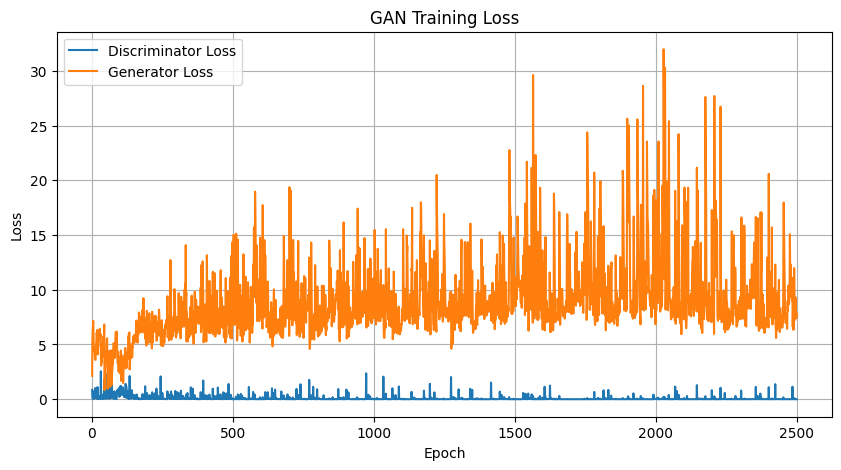

In [23]:
G1.train()
train_gan(G1, D1, train_loader, device, optimizer_D1, optimizer_G1, epochs=50, latent_dim=100)


In [72]:
# Visualizar segmento
G1.to(device)
G1.eval()
p = torch.randn(1, 100, 1, 4).to(device)
fake1 = G1(p)
visualizar_segmento(fake1[0], idx2char)


--------------------------------
--------------------------------
--------------------------------
--------------------------------
---------------------------oo---
-------------------------XX-----
--------------------------------
--------------------------------
--------------------------------
----------------XXXXXX----------
---------E----------------------
--------------------------------
-----XXXX------------------XXXXX
XXXXXXXXX-----------------------


Forma de fake1: torch.Size([1, 13, 14, 32])


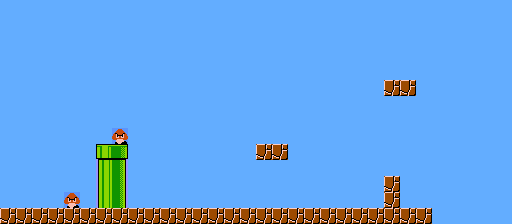

In [56]:
# Visualizar imagen
print(f"Forma de fake1: {fake1.shape}")
if len(fake1.shape) == 4:
    fake1_fixed = fake1.squeeze(0)
    imagen_resultado1 = tensor_a_imagen(fake1_fixed, idx2char, sprites)
display(imagen_resultado1)

### Entrenamiento Modelo 2

Epoch 2500/2500: 100%|██████████| 11/11 [00:00<00:00, 11.73it/s, D_loss=0.00523, G_loss=7.98]


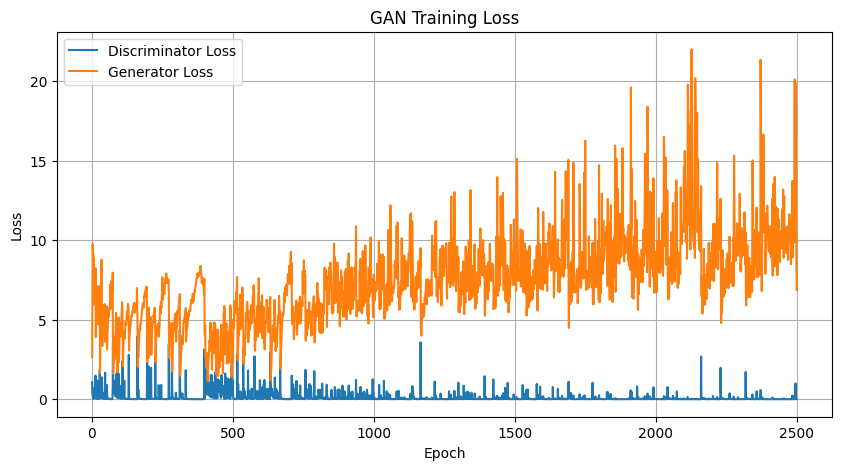

In [73]:
G2.train()
train_gan(G2, D2, train_loader, device, optimizer_D2, optimizer_G2, epochs=2500, latent_dim=100)

In [121]:
# Visualizar segmento
G2.to(device)
G2.eval()
p = torch.randn(1, 100, 1, 4).to(device)
fake2 = G2(p)
visualizar_segmento(fake2[0], idx2char)

--------------------------------
--------------------------------
--------------------------------
--------------------------------
--------------------------------
---SSSS-------------------------
--------------------------------
---S-E--------------------------
------------------------------E-
---SSSSSSS-------------->---S<>-
-----------------------------[]-
-----]-------------------]----]-
---------------------EE----X-[--
-----XXXXXXXXXXXXXXXXXXXXXXXXXX-


Forma de fake2: torch.Size([1, 13, 14, 32])


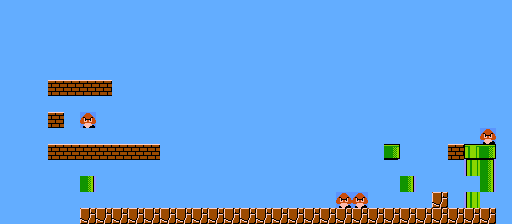

In [122]:
# Visualizar imagen
print(f"Forma de fake2: {fake2.shape}")
if len(fake2.shape) == 4:
    fake2_fixed = fake2.squeeze(0)
    imagen_resultado2 = tensor_a_imagen(fake2_fixed, idx2char, sprites)
display(imagen_resultado2)

### Entrenamiento Modelo 3

Epoch 2500/2500: 100%|██████████| 11/11 [00:00<00:00, 17.71it/s, D_loss=0.092, G_loss=3.24]


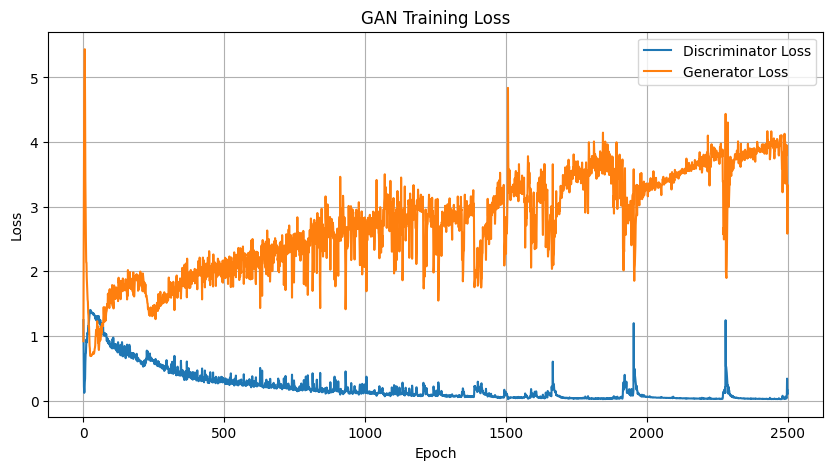

In [128]:
G3.train()
train_gan(G3, D3, train_loader, device, optimizer_D3, optimizer_G3, epochs=2500, latent_dim=100)

In [177]:
# Visualizar segmento
G3.to(device)
G3.eval()
p = torch.randn(1, 100, 1, 4).to(device)
fake3 = G3(p)
visualizar_segmento(fake3[0], idx2char)

--------------------------------
--------------------------------
--------------------------------
--------------------------------
--------------------------------
--------------------------------
--------------------------------
--------------------------------
-SSS-SSSS-----X-----------------
------------XX------------------
-----------XXX-------E----------
----------XXXX------<>------<>--
---------XXXXX------[]------[]--
X-XX-XXXXXXXXXXXXXXXXXXXXXXXXXXX


Forma de fake2: torch.Size([1, 13, 14, 32])


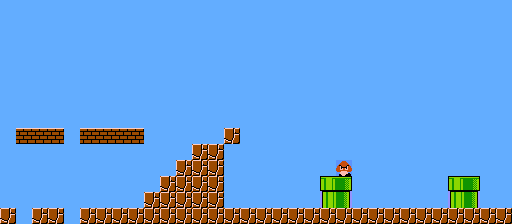

In [178]:
# Visualizar imagen
print(f"Forma de fake2: {fake3.shape}")
if len(fake3.shape) == 4:
    fake3_fixed = fake3.squeeze(0)
    imagen_resultado3 = tensor_a_imagen(fake3_fixed, idx2char, sprites)
display(imagen_resultado3)

# Conclusión

| Modelo                          | Complejidad | Tipo de bloques       | Ventaja principal                                                    |
| ------------------------------- | ----------- | --------------------- | -------------------------------------------------------------------- |
| `GAN Densa` | Alta        | DenseBlocks           | Reutilización de características, profundidad eficiente              |
| `GAN residual` | Media-Alta  | ResidualBlocks        | Entrenamiento profundo estable, gradiente fluido                     |
| `GAN tradicional` | Baja        | Convoluciones simples | Simplicidad, entrenamiento más rápido y menos propenso a overfitting |


Todas las redes fueron entrenadas con 2550 epochs y concluimos que la mejor es la tradicional ya que es mucho mas rapida de entrenar y da resultados similares a la densa, por otro lado la residual dio peores resultados aunque al momento de entrenarla fue mas rapido que la densa